In [1]:
# imports
import sys, os
sys.path.append(os.getcwd()+'/code')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import Algorithms
from data_streamer import Streamer, MultiStreamer

In [2]:
# constants
train_data_file=os.getcwd() + '/data/train_mnist_normalized.csv'
validation_data_file=os.getcwd() + '/data/test_mnist_normalized.csv'
assert os.path.isfile(train_data_file)
k = 10 # dimensionality of representations
d=784
learning_rate = 1e-3 # initial learning rate
validation_freq = 1000 # how many training steps in between validations

In [3]:
# data streamer and algorithm
train_stream = Streamer(train_data_file).get_stream()
algorithm=Algorithms.oja({'d': d, 'k': k, 'learning_rate': learning_rate, 'mean_center': 0.0})
# load validation data at once to make validation faster
validation_data, training_data=[],[]
for point in Streamer(validation_data_file).get_stream():
    validation_data.append(point)
for point in Streamer(train_data_file).get_stream():
    training_data.append(point)
validation_data=np.stack(validation_data,axis=0)
training_data=np.stack(training_data,axis=0)
# do PCA on the validation as a lower bound
centered_data=validation_data #- np.mean(validation_data,axis=0,keepdims=True)
lambdas,_=np.linalg.eigh(np.matmul(centered_data.T,centered_data))
lambdas=sorted(lambdas)
best_validation_loss=sum(lambdas[:-k])/(centered_data.shape[0]*centered_data.shape[1])

In [4]:
# placeholders for loss
validation_loss, training_loss, min_training_loss = [], [], []
training_batch = []
# main loop
counter=0
train_stream = Streamer(train_data_file).get_stream()
for point in train_stream:
    counter+=1
    algorithm.step(point)
    if counter%validation_freq==0:
        print(counter)
        loss=algorithm.loss(validation_data)
        loss/=(validation_data.shape[0]*validation_data.shape[1])
        validation_loss.append(loss)
        loss=algorithm.loss(training_data)
        loss/=(training_data.shape[0]*training_data.shape[1])
        training_loss.append(loss)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000


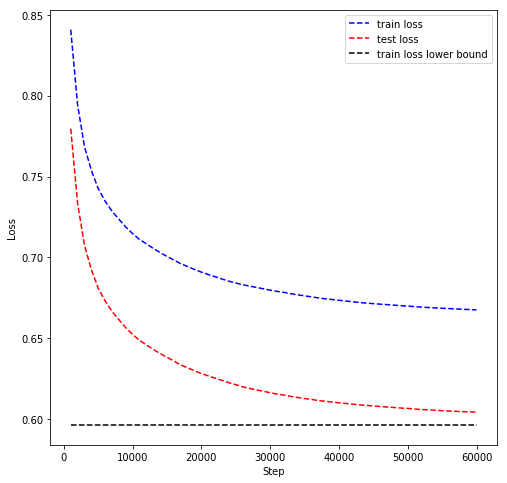

In [5]:
# plot the train and test loss
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Loss')
x_scale=[x*validation_freq for x in range(1,len(training_loss)+1)]
plt.plot(x_scale, training_loss, '--b', label='train loss')
plt.plot(x_scale, validation_loss, '--r', label='test loss')
plt.plot(x_scale, [best_validation_loss]*len(training_loss), '--k', label='train loss lower bound')
_ = plt.legend()